In [105]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings as stfu
import numpy as np
from utils import *
from sklearn.linear_model import LinearRegression
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
stfu.filterwarnings('ignore')

## California Housing

In [106]:
california = pd.read_csv('data/california.csv')
california.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


<AxesSubplot: xlabel='MedHouseVal', ylabel='Density'>

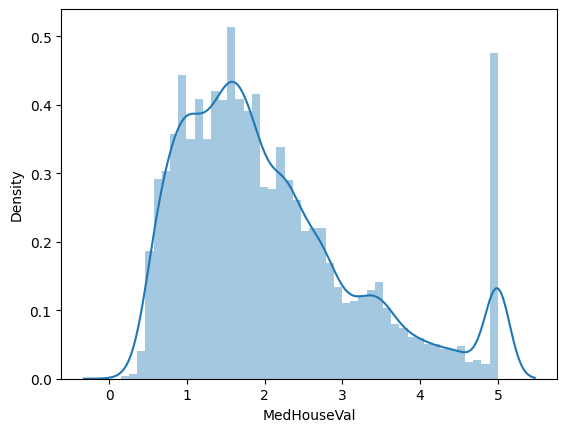

In [107]:
sns.distplot(california['MedHouseVal'])

## Fish weight prediction

In [108]:
fish = pd.read_csv('data/fish.csv')
fish.head()

,Species,Weight,Length1,Length2,Length3,Height,Width
0,Bream,242.0,23.2,25.4,30.0,11.5200,4.0200
1,Bream,290.0,24.0,26.3,31.2,12.4800,4.3056
2,Bream,340.0,23.9,26.5,31.1,12.3778,4.6961
3,Bream,363.0,26.3,29.0,33.5,12.7300,4.4555
4,Bream,430.0,26.5,29.0,34.0,12.4440,5.1340


<AxesSubplot: xlabel='Weight', ylabel='Density'>

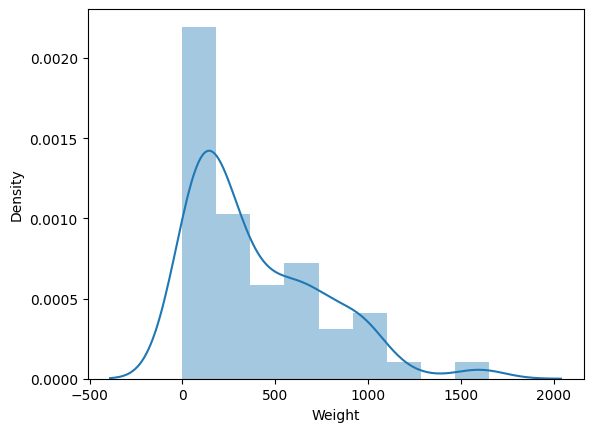

In [109]:
sns.distplot(fish['Weight'])

## Mix-IRLS implementation

In [160]:
# import sklearn cluster
from sklearn.cluster import KMeans
class MixIRLSRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, beta_init, opts_input={}):
        self.opts_input = opts_input
        self.beta_init = beta_init
        self.iter = None
        self.beta_hat = None
        self.cluster_centroids = None
        self.train_X = None
        self.train_y = None

    def fit(self, X, y):
        self.beta_hat, self.iter = self._MixIRLS(X, y, self.beta_init, self.opts_input)
        return self

    def predict(self, X):
        pseudo_residuals = np.abs(X @ self.beta_hat)
        clusters = np.argmin(pseudo_residuals, axis=1)

        predictions = np.zeros(X.shape[0])

        for i in range(X.shape[0]):
            cluster = clusters[i]
            predictions[i] = X[i] @ self.beta_hat[:, cluster]

        return predictions

    def _MixIRLS(self, X, y, beta_init, opts_input={}):
        opts = dict()
        opts['verbose'] = False # let MixIRLS chat
        opts['T1'] = int(1e3) # phase I inner IRLS maximal number of iterations
        opts['T2'] = int(1e3) # phase II maximal number of iterations
        opts['wfun'] = lambda r: 1 / (1 + r**2) # IRLS function
        opts['rho'] = 2. # oversampling parameter. Set to 2 in real-data experiments
        opts['nu'] = 1 # tuning parameter. Set to 1 in real-data experiments
        opts['w_th_init'] = 0.1 # initialization for threshold parameter w_th
        opts['corrupt_frac'] = 0 # fraction of outliers
        opts['unknownK'] = True # if true, assumes K is unknown
        opts['tol'] = 2e-16 # tolerance for stopping criterion
        opts['errfun'] = lambda beta_hat: -1 # error function (unknown by default). Used only if verbose is on
        
        for key in opts_input.keys():
            opts[key] = opts_input[key]

        ## set parameters
        n, d = X.shape
        K = beta_init.shape[1]
        verbose = opts['verbose']
        
        beta_hat = np.zeros((d,K))
        supports = np.ones((n,K), dtype=np.bool8)
        w_th = opts['w_th_init']
        first_component_w = np.zeros_like(y)

        iter = 0
        k = 0
        while k < K:
            curr_X = X[supports[:,k],:]
            curr_y = y[supports[:,k]]

            if k==0 and np.any(first_component_w):
                if verbose:
                    print('use same component 1')
                w = first_component_w
                beta_hat[:, 1:] = 0
            else:
                if verbose:
                    print('find component ' + str(k+1))

                [beta, w, inner_iter] = find_component(curr_X, curr_y, opts['wfun'], \
                    opts['nu'], opts['rho'], opts['T1'], beta_init[:,k], verbose)
                iter = iter + inner_iter

                beta_hat[:,k]= beta
                if k==0: 
                    first_component_w = w
            
            next_oversampling = max(0, np.count_nonzero(w <= w_th) - opts['corrupt_frac'] * n) / d
            if not opts['unknownK'] and (k < K-1) and (next_oversampling < opts['rho']):
                if verbose:
                    print('w_th ' + str(w_th) + ' is too low! Starting over...')
                w_th = w_th + 0.1
                k = 0
                continue
            else:
                new_support = supports[:, k].copy()
                new_support[new_support] = (w <= w_th)
                if k < K-1:
                    supports[:, k+1] = new_support

            if verbose:
                print('MixIRLS. error: ' + '{:.3e}'.format(opts['errfun'](beta_hat)) + ', \tk: ' + str(k+1))

            if opts['unknownK'] and (next_oversampling < opts['rho']):
                K = k+1
                beta_hat = beta_hat[:, :K]
                if verbose:
                    print('MixIRLS. found K=' + str(K) + ' components, stopping here')
                break

            k = k + 1

        beta_diff = 1
        iter_phase2 = 0
        while (beta_diff > opts['tol']) and (iter_phase2 < opts['T2']):
            beta_hat_prev = beta_hat
            res2 = np.zeros((len(y), K))
            for k in range(K):
                res2[:, k] = abs(X @ beta_hat[:, k] - y)**2

            w = 1 / (res2 + 1e-16)
            w = w / np.sum(w + 1e-16, axis=1)[:, np.newaxis]
            highs = np.any(w>=2/3, axis=1)
            w_highs = w[highs,:]
            w_highs[w_highs>=2/3] = 1
            w_highs[w_highs<2/3] = 0
            w[highs,:] = w_highs
            lows = np.any(w<1/K, axis=1)
            w_lows = w[lows,:]
            w_lows[w_lows<1/K] = 0
            w[lows,:] = w_lows
            w = w / np.sum(w + 1e-16, axis=1)[:, np.newaxis]

            outlier_indicator = detect_outliers(res2, opts['corrupt_frac'])
            samples_to_use = ~outlier_indicator

            for k in range(K):
                    beta_hat[:, k] = weighted_ls(X[samples_to_use,:], y[samples_to_use], w[samples_to_use,k])
            beta_diff = np.linalg.norm(beta_hat - beta_hat_prev, 'fro') / np.linalg.norm(beta_hat, 'fro')
    
            iter_phase2 = iter_phase2 + 1
            if verbose and (iter_phase2 % 10 == 0):
                print('Mix-IRLS. error: ' + '{:.3e}'.format(opts['errfun'](beta_hat)) + ', \tphase2-iter: ' + str(iter_phase2))
        
        iter = iter + iter_phase2
        return beta_hat, iter

In [161]:
def compare(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    linear_regressor = LinearRegression()
    mirls_regressor = MixIRLSRegressor(beta_init = np.random.rand(X.shape[1], 2))

    linear_regressor.fit(X_train, y_train)
    mirls_regressor.fit(X_train, y_train)

    linear_pred = linear_regressor.predict(X_test)
    mirls_pred = mirls_regressor.predict(X_test)
    
    linear_mse = mean_squared_error(y_test, linear_pred)
    mirls_mse = mean_squared_error(y_test, mirls_pred)

    print(f"Linear MSE: {linear_mse}, r2: {r2_score(y_test, linear_pred)}")
    print(f"MIRLS MSE: {mirls_mse}, r2: {r2_score(y_test, mirls_pred)}")

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.scatter(y_test, linear_pred)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=3)
    plt.title('Linear Regression')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')

    plt.subplot(1, 2, 2)
    plt.scatter(y_test, mirls_pred)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=3)
    plt.title('MIRLS Regression')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')

    plt.show()


Linear MSE: 0.5209155172088054, r2: 0.6045666403842586
MIRLS MSE: 0.5443434992528834, r2: 0.5867821718041192


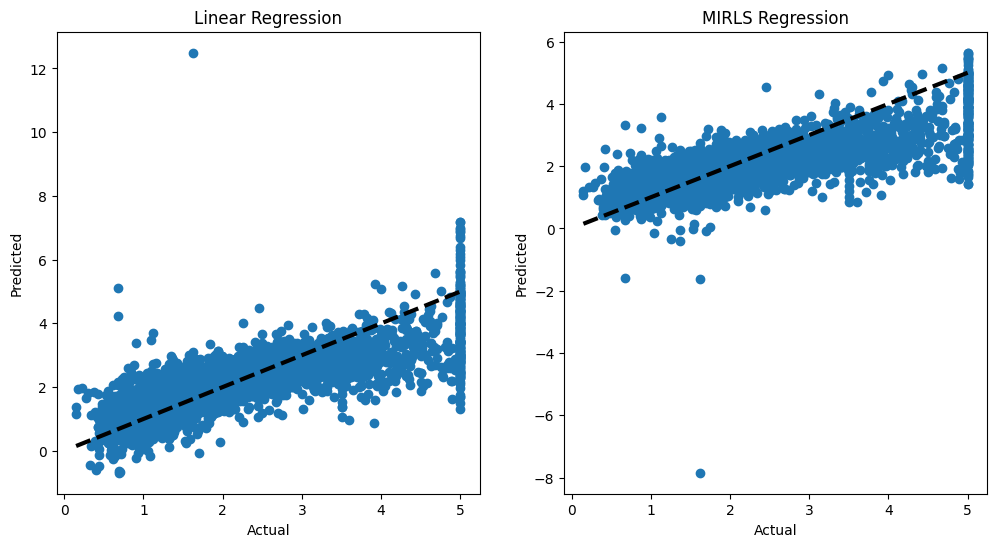

In [162]:
y = california['MedHouseVal']
X = california.drop('MedHouseVal', axis=1)
compare(X.values, y.values)

Linear MSE: 20220.66783631331, r2: 0.8512994995330222
MIRLS MSE: 44812.1642175532, r2: 0.6704564211182117


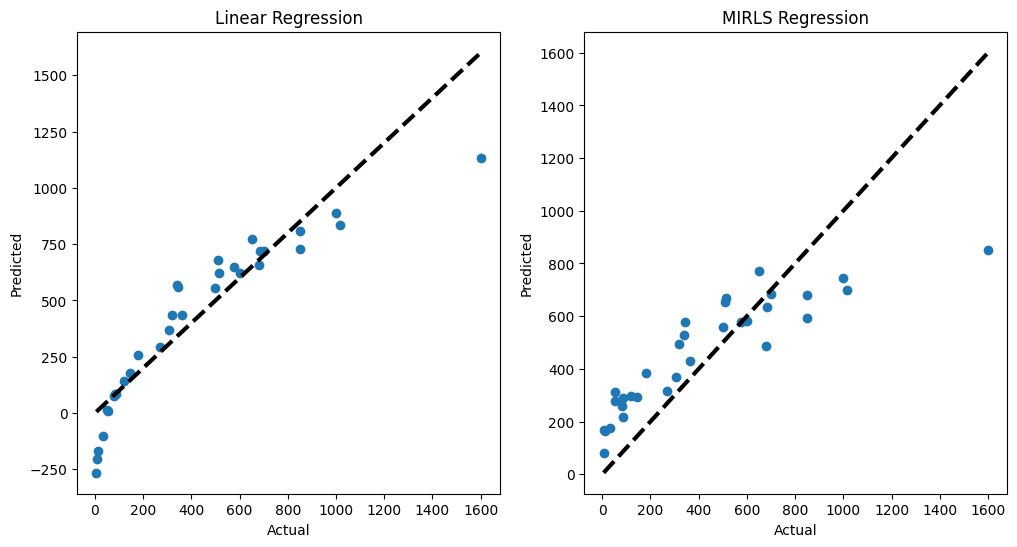

In [163]:
y = fish['Weight']
X = fish.drop(['Weight', 'Species'], axis=1)
compare(X.values, y.values)